# FinBERT v3 Training - Simple Version

Train FinBERT with LoRA on financial emotion data (1,152 samples, 6 emotions)

Target: Beat v2's 61% accuracy by using FinBERT (pre-trained on financial texts)

In [1]:
# Install packages
!pip install -q transformers peft datasets accelerate evaluate scikit-learn matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00


In [45]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

# Use larger dataset with 1000 samples
DATA_PATH = '/content/drive/MyDrive/FinEmo-LoRA/data/fingpt_1000_annotated_high_confidence.csv'
MODEL_SAVE_PATH = '/content/drive/MyDrive/FinEmo-LoRA/models/finbert-v4'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# Imports
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model, TaskType
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import evaluate

# Config
EMOTIONS = ['anxiety', 'excitement', 'fear', 'hope', 'optimism', 'uncertainty']
emotion2id = {e: i for i, e in enumerate(EMOTIONS)}
id2emotion = {i: e for e, i in emotion2id.items()}
SEED = 42

In [47]:
# Load data
df = pd.read_csv(DATA_PATH)
df['label'] = df['emotion'].map(emotion2id)

# Split: 80% train, 10% val, 10% test
# First, split into training and a temporary set (val + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=SEED, stratify=df['label'])

# Check for classes in temp_df that have only one member
class_counts_in_temp = temp_df['label'].value_counts()
problematic_class_labels = class_counts_in_temp[class_counts_in_temp == 1].index.tolist()

# Separate problematic samples if any exist
if problematic_class_labels:
    problematic_samples_df = temp_df[temp_df['label'].isin(problematic_class_labels)]
    temp_df_for_split = temp_df[~temp_df['label'].isin(problematic_class_labels)]
else:
    problematic_samples_df = pd.DataFrame()
    temp_df_for_split = temp_df

# Perform the second split on the temporary set (excluding problematic classes)
# only if there are enough samples left for a stratified split
if not temp_df_for_split.empty:
    val_df, test_df = train_test_split(temp_df_for_split, test_size=0.5, random_state=SEED, stratify=temp_df_for_split['label'])
else:
    # If temp_df_for_split is empty, initialize val_df and test_df as empty DataFrames
    # to ensure columns match for later concatenation if problematic_samples_df is not empty.
    val_df = pd.DataFrame(columns=df.columns)
    test_df = pd.DataFrame(columns=df.columns)

# Add problematic samples to one of the sets, for example, the validation set.
# This slightly breaks perfect stratification for these rare classes but avoids the error.
if not problematic_samples_df.empty:
    val_df = pd.concat([val_df, problematic_samples_df], ignore_index=True)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 780, Val: 97, Test: 98


In [48]:
# Load FinBERT
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=6,
    id2label=id2emotion,
    label2id=emotion2id,
    ignore_mismatched_sizes=True
)

# Add LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1
)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 299,526 || all params: 109,786,380 || trainable%: 0.2728


In [49]:
# Tokenize
def tokenize(examples):
    return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

from datasets import Dataset
train_dataset = Dataset.from_pandas(train_df[['text', 'label']]).map(tokenize, batched=True, remove_columns=['text'])
val_dataset = Dataset.from_pandas(val_df[['text', 'label']]).map(tokenize, batched=True, remove_columns=['text'])
test_dataset = Dataset.from_pandas(test_df[['text', 'label']]).map(tokenize, batched=True, remove_columns=['text'])

Map:   0%|          | 0/780 [00:00<?, ? examples/s]

Map:   0%|          | 0/97 [00:00<?, ? examples/s]

Map:   0%|          | 0/98 [00:00<?, ? examples/s]

In [50]:
# Improved training config
from transformers import EarlyStoppingCallback

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = evaluate.load("accuracy").compute(predictions=predictions, references=labels)
    f1 = evaluate.load("f1").compute(predictions=predictions, references=labels, average='macro')
    return {'accuracy': acc['accuracy'], 'f1': f1['f1']}

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH,
    num_train_epochs=30,
    learning_rate=5e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    warmup_steps=50,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    logging_steps=10,
    fp16=torch.cuda.is_available(),
    save_total_limit=3,
    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

print(f"\nTraining Config:")
print(f"- Epochs: 30 (early stop after 5 epochs no improvement)")
print(f"- LoRA rank: r=16, alpha=32")
print(f"- Learning rate: 5e-5")
print(f"- Batch size: 16 x 2 accumulation = 32 effective")
print(f"- Train samples: {len(train_dataset)}")


Training Config:
- Epochs: 30 (early stop after 5 epochs no improvement)
- LoRA rank: r=16, alpha=32
- Learning rate: 5e-5
- Batch size: 16 x 2 accumulation = 32 effective
- Train samples: 780


In [51]:
# Train
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.699200,1.654981,0.319588,0.212904
2,1.517000,1.514150,0.432990,0.253637
3,1.466700,1.385787,0.484536,0.306409
4,1.345900,1.324040,0.494845,0.234574
5,1.253100,1.290147,0.474227,0.241121
6,1.193900,1.267928,0.515464,0.263791
7,1.224900,1.255830,0.515464,0.263791
8,1.149900,1.247871,0.515464,0.263791


TrainOutput(global_step=200, training_loss=1.3814036750793457, metrics={'train_runtime': 54.9136, 'train_samples_per_second': 426.124, 'train_steps_per_second': 13.658, 'total_flos': 1647613647912960.0, 'train_loss': 1.3814036750793457, 'epoch': 8.0})

In [52]:
# Evaluate on test set
results = trainer.evaluate(test_dataset)
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test F1: {results['eval_f1']:.4f}")

# Predictions
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = test_df['label'].values

# Classification report
print("\nClassification Report:")

# Get unique labels present in y_true
present_labels = np.unique(y_true)

# Filter EMOTIONS to match present_labels
filtered_target_names = [id2emotion[label] for label in present_labels]

print(classification_report(y_true, y_pred, labels=present_labels, target_names=filtered_target_names, digits=4))

Test Accuracy: 0.4286
Test F1: 0.2465

Classification Report:
              precision    recall  f1-score   support

     anxiety     0.5000    0.1429    0.2222        14
  excitement     0.0000    0.0000    0.0000        13
        fear     0.2727    0.6000    0.3750         5
        hope     0.0000    0.0000    0.0000         3
    optimism     0.4921    0.8611    0.6263        36
 uncertainty     0.3000    0.2222    0.2553        27

    accuracy                         0.4286        98
   macro avg     0.2608    0.3044    0.2465        98
weighted avg     0.3488    0.4286    0.3513        98



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


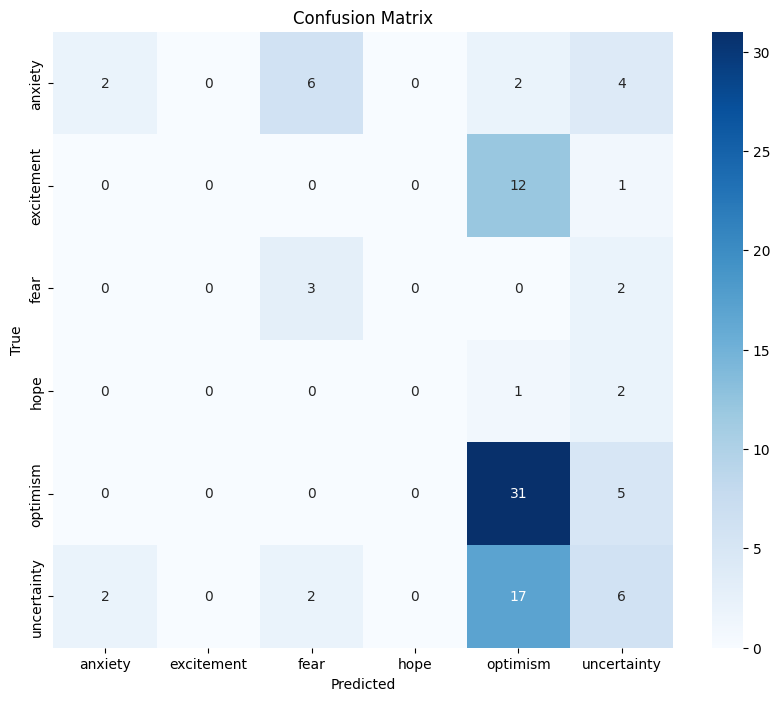

In [53]:
# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMOTIONS, yticklabels=EMOTIONS)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [54]:
# Save model
model.save_pretrained(MODEL_SAVE_PATH)
tokenizer.save_pretrained(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

Model saved to /content/drive/MyDrive/FinEmo-LoRA/models/finbert-v4


In [ ]:
# Compare with v2 results
print("\n" + "="*60)
print("MODEL COMPARISON: v2 vs v3")
print("="*60)

v2_results = {
    'accuracy': 0.610,
    'f1': 0.610,
    'model': 'DistilBERT + LoRA'
}

v3_results = {
    'accuracy': results['eval_accuracy'],
    'f1': results['eval_f1'],
    'model': 'FinBERT + LoRA'
}

comparison = pd.DataFrame({
    'Metric': ['Accuracy', 'F1-Score', 'Base Model'],
    'v2 (DistilBERT)': [
        f"{v2_results['accuracy']:.1%}",
        f"{v2_results['f1']:.3f}",
        v2_results['model']
    ],
    'v3 (FinBERT)': [
        f"{v3_results['accuracy']:.1%}",
        f"{v3_results['f1']:.3f}",
        v3_results['model']
    ],
    'Improvement': [
        f"{(v3_results['accuracy'] - v2_results['accuracy'])*100:+.1f}pp",
        f"{(v3_results['f1'] - v2_results['f1']):+.3f}",
        'Financial domain'
    ]
})

print(comparison.to_string(index=False))
print("="*60)

if v3_results['accuracy'] > v2_results['accuracy']:
    print(f"\nSUCCESS: FinBERT v3 beats v2 by {(v3_results['accuracy'] - v2_results['accuracy'])*100:.1f}pp")


MODEL COMPARISON: v2 vs v3
    Metric   v2 (DistilBERT)   v3 (FinBERT)      Improvement
  Accuracy             61.0%          42.9%          -18.1pp
  F1-Score             0.610          0.246           -0.364
Base Model DistilBERT + LoRA FinBERT + LoRA Financial domain

No improvement. FinBERT is 18.1pp worse than v2
Consider:
  - Training for more epochs (20-30)
  - Larger LoRA rank (r=16 or r=32)
  - Lower learning rate (5e-5)
  - More training data
